In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import sys
import os
from pathlib import Path
from importlib import reload

sys.path.append('../')
import waveform_processing as proc
reload(proc)

<module 'waveform_processing' from '../waveform_processing.py'>

In [5]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

In [6]:
res_path = Path('/reg/d/psdm/sxr/sxrx30416/results/espov/')

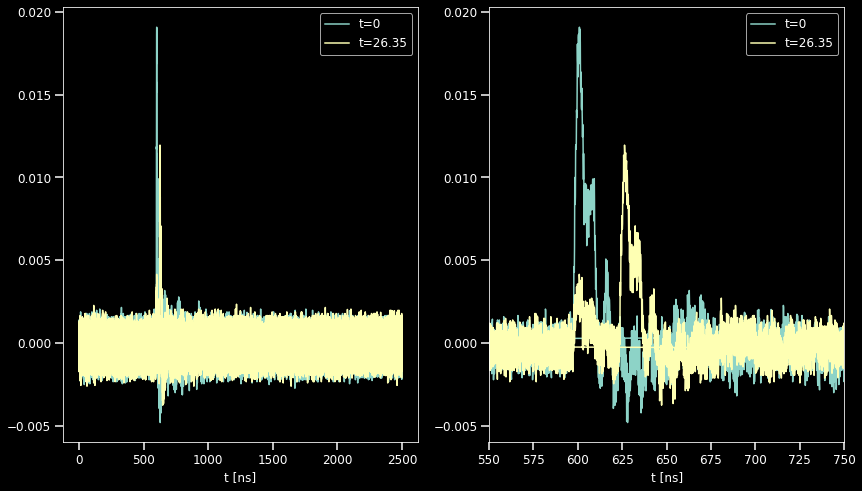

In [7]:
runs = [8,12] # 8: single pulse, 12 two-pulse
dat = []
for ii, run in enumerate(runs):
    fname = res_path / 'MCP_data' / 'MCP_r{}_small.h5'.format(run)
    with h5.File(fname, 'r') as f:
        dat.append(np.asarray(f['MCP']))

plt.figure(figsize=(14,8))
ax = plt.subplot(121)
t = dat[0][0,0]
sig = dat[0][0,1]
ax.plot(t,sig, label='t=0')

t = dat[1][1,0]
sig = dat[1][1,1]
ax.plot(t,sig, label='t=26.35')
ax.legend()
ax.set_xlabel('t [ns]')

ax = plt.subplot(122)
t = dat[0][0,0]
sig = dat[0][0,1]
ax.plot(t,sig, label='t=0')
t = dat[1][1,0]
sig = dat[1][1,1]
ax.plot(t,sig, label='t=26.35')

ax.legend()
ax.set_xlim(550,750)
ax.set_xlabel('t [ns]')
plt.show()

## Remove background and smooth data

In [8]:
from scipy.signal import savgol_filter

def removeBackground(signal, ave_window=[0,500]):
    """
    Set the baseline of the waveform to 0
    """
    if signal.ndim ==1:
        return signal - np.median(signal[ave_window[0]:ave_window[1]])
    elif signal.ndim==2:
        med = np.median(signal[:,ave_window[0]:ave_window[1]], axis=1)  
        return signal - med.reshape(med.shape[0],1)

singlePulseData = removeBackground(dat[0][:,1,:])
twoPulseData = removeBackground(dat[1][:,1,:])

def filt(waveform, method='savgol', **kwargs):
    if method is 'savgol':
        if 'window_length' in kwargs:
            window_length = kwargs.pop('window_length')
        else:
            window_length = 15
        if 'polyorder' in kwargs:
            polyorder = kwargs.pop('polyorder')
        else:
            polyorder = 3
        return savgol_filter(waveform, window_length, polyorder)
    elif method is 'fft':
        if 'threshold' in kwargs:
            threshold = kwargs.pop('threshold')
        else:
            threshold = 1000
        ft = np.fft.rfft(waveform)
        ft[threshold:] = 0
        return np.fft.irfft(ft)
    
singlePulseData = filt(singlePulseData, window_length=15)[:, 4500:6000]
twoPulseData = filt(twoPulseData, window_length=15)[:, 4500:6000]

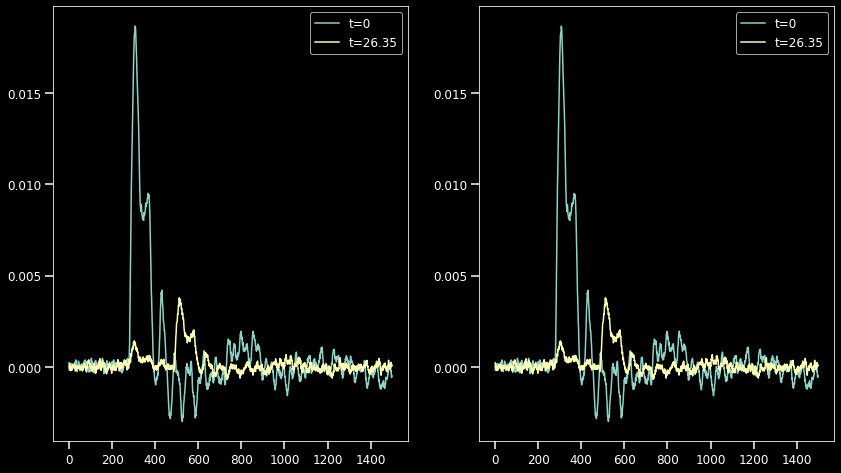

In [9]:
plt.figure(figsize=(14,8))
ax = plt.subplot(121)
sig = singlePulseData[0]
ax.plot(sig, label='t=0')

sig = twoPulseData[0]
ax.plot(sig, label='t=26.35')
ax.legend()

ax = plt.subplot(122)
sig = singlePulseData[0]
ax.plot(sig, label='t=0')
sig = twoPulseData[0]
ax.plot(sig, label='t=26.35')

ax.legend()
# ax.set_xlim(4500,6000)
plt.show()

# Single pulse traces

In [10]:
singlePulseData.shape

(493, 1500)

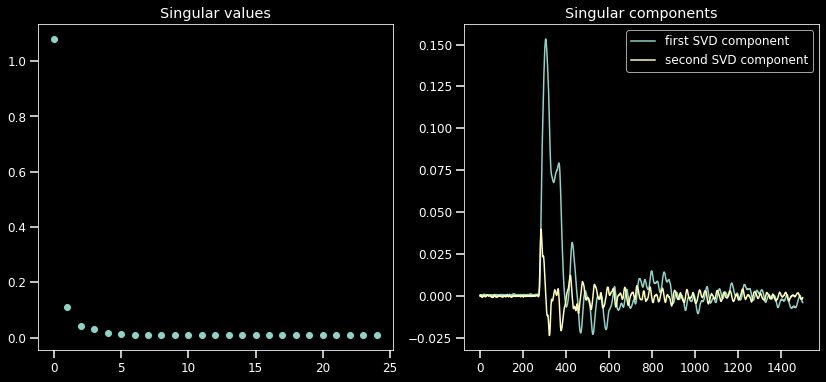

In [12]:
A, projector, svd = proc.get_basis_and_projector(singlePulseData[:150], n_components=1)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(svd.singular_values_,'o')
plt.title('Singular values')

plt.subplot(1,2,2)
plt.plot(svd.components_[0], label='first SVD component')
plt.plot(0.2*svd.components_[1], label='second SVD component')
# plt.plot(svd.components_[3], 'r', label='third SVD component')
plt.title('Singular components')
plt.legend()
# plt.xlim(4500,6500)
plt.show()

Pulse intensity (norm of 1 coefficients) = 0.119973
[0.11997281]


Pulse intensity (norm of 1 coefficients) = 0.120252
[ 0.11997281 -0.00741652 -0.00139361 -0.00245453 -0.00201217]


Pulse intensity (norm of 1 coefficients) = 0.120271
[ 1.19972809e-01 -7.41651709e-03 -1.39360579e-03 -2.45452867e-03
 -2.01217401e-03 -3.38631269e-04  6.52263023e-05  4.20166609e-04
 -3.58439225e-04 -1.06496852e-04  4.18379047e-04  1.04420569e-03
  1.62117401e-03  3.56058320e-04  5.22333044e-04]




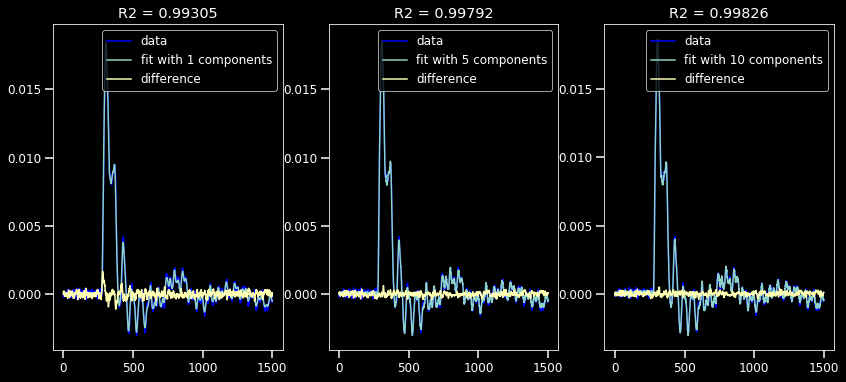

In [9]:
regr = proc.construct_waveformRegressor(singlePulseData[:150], n_components=1)
coeffs = regr.fit(singlePulseData[0]).coeffs_
print('Pulse intensity (norm of 1 coefficients) = {:.6f}'.format(np.linalg.norm(coeffs)))
print(coeffs)
print('\n')
fit = regr.fit_reconstruct(singlePulseData[0])
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.plot(singlePulseData[0], 'b', label='data')
plt.plot(fit, label='fit with 1 components')
plt.plot(fit-singlePulseData[0], label='difference')
# plt.xlim(4500,6000)
r2 = regr.score(singlePulseData[0])
plt.title('R2 = {:.5f}'.format(r2))
plt.legend()

regr = proc.construct_waveformRegressor(singlePulseData[:150], n_components=5)
coeffs = regr.fit(singlePulseData[0]).coeffs_
print('Pulse intensity (norm of 1 coefficients) = {:.6f}'.format(np.linalg.norm(coeffs)))
print(coeffs)
print('\n')
fit = regr.fit_reconstruct(singlePulseData[0])
plt.subplot(1,3,2)
plt.plot(singlePulseData[0], 'b', label='data')
plt.plot(fit, label='fit with 5 components')
plt.plot(fit-singlePulseData[0], label='difference')
# plt.xlim(4500,6000)
r2 = regr.score(singlePulseData[0])
plt.title('R2 = {:.5f}'.format(r2))
plt.legend()

regr = proc.construct_waveformRegressor(singlePulseData[:150], n_components=15)
coeffs = regr.fit(singlePulseData[0]).coeffs_
print('Pulse intensity (norm of 1 coefficients) = {:.6f}'.format(np.linalg.norm(coeffs)))
print(coeffs)
print('\n')
fit = regr.fit_reconstruct(singlePulseData[0])
plt.subplot(1,3,3)
plt.plot(singlePulseData[0], 'b', label='data')
plt.plot(fit, label='fit with 10 components')
plt.plot(fit-singlePulseData[0], label='difference')
# plt.xlim(4500,6000)
r2 = regr.score(singlePulseData[0])
plt.title('R2 = {:.5f}'.format(r2))
plt.legend()

plt.show()

# Two pulse analysis

## (i) Construct the two-pulse basis

The two-pulse basis is constructed from two single pulse basis, shifted with respect to each other by the priorly know delay between the pulses.
Below is an example using one single-pulse component. Note that there is no limitation on how many single-pulse component can be used.

In [10]:
reload(proc)
dl = 26.35
n_components = 2
regr2 = proc.construct_waveformRegressor(singlePulseData[:150], 
                                         n_components=n_components, 
                                         method='pinv',
                                         n_pulse=2, 
                                         delay=dl)

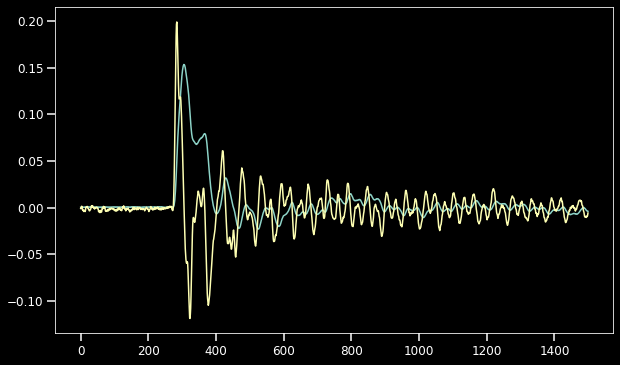

In [11]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(regr2.A[0,:], label='pulse 1')
plt.plot(regr2.A[1,:], label='pulse 2')
# plt.plot(twoPulseData[0]*15, label='data')
# plt.xlim(4400,6500)

plt.show()

Two-pulse basis vectors.

## (ii) Project the two-pulse basis onto the waveforms

165
r2 = 0.693
33
r2 = 0.963
119
r2 = 0.927
275
r2 = 0.789
335
r2 = 0.975
131
r2 = 0.980


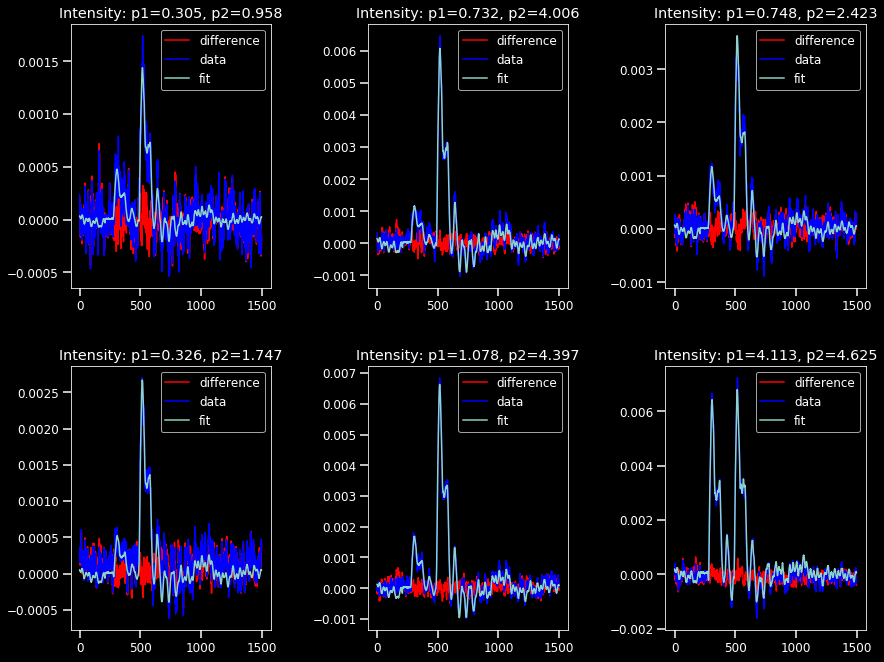

In [12]:
regr2 = proc.construct_waveformRegressor(singlePulseData[:150], 
                                         n_components=n_components, 
                                         method='pinv',
                                         n_pulse=2, 
                                         delay=dl)

plt.figure(figsize=(13,10))
for ii in range(6):
    ind = np.random.randint(twoPulseData.shape[0])
    fit, r2 = regr2.fit_reconstruct(twoPulseData[ind], return_score=True)
    p1, p2, p1_max, p2_max = regr2.get_pulse_intensity(twoPulseData[ind])
    
    ax = plt.subplot(2,3,ii+1)
    ax.set_title('Intensity: p1={:.3f}, p2={:.3f}'.format(p1*100, p2*100))
    ax.plot(twoPulseData[ind]-fit, 'r', label='difference')
    ax.plot(twoPulseData[ind], 'b', label='data')
    ax.plot(fit, label='fit')
    ax.legend()
#     ax.set_xlim(4400,6000)
    
    print(ind)
    print('r2 = {:.3f}'.format(r2))
    
plt.tight_layout(pad=3)
plt.show()

Some two-pulse fit examples.

(10, 1500)


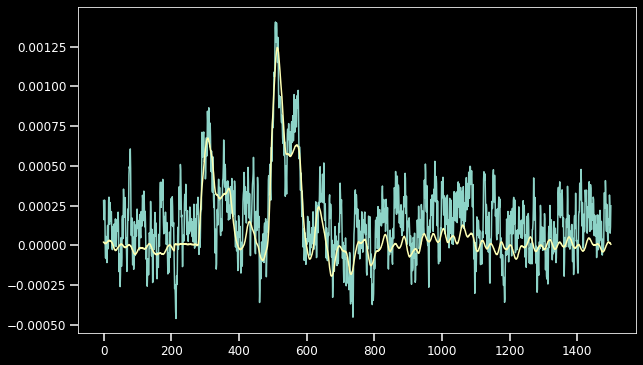

0.8357021987940374


In [13]:
""" Test multi waveforms fit """
y = regr2.fit_reconstruct(twoPulseData[:10])
print(y.shape)
plt.plot(twoPulseData[5])
plt.plot(y[5])
plt.show()
print(regr2.score(twoPulseData[:10]))

## cross val score

In [14]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(regr2, twoPulseData, None, cv=5)